# Выпускной проект (промышленность)

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали

## Задание

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Этапы работы

Работа делится на 3 этапа:
- план работы;
- код решения;
- отчет по решению.

#### Задание первого этапа работы

Проведите исследовательский анализ данных. В конце Jupyter Notebook напишите:
- список уточняющих вопросов;
- примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями;
- цель проекта.

#### Задание второго этапа работы

Загрузите код вашего решения задачи.

#### Задание третьего этапа работы

Неизвестно на данном этапе.

## Этап - 1. Исследовательский анализ данных.

### Импорт библиотек

Установка catboost (проект выполняется локально, установленной библиотеки не оказалось). Закомментил строку для сдачи работы на проверку.

In [1]:
#pip install catboost

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
#import lightgbm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

Настройка отображения таблиц.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Random State зафиксированный для выполнения задач.

In [4]:
random_state = 240423

### Самописные функции

Функция вывода базовой информации о данных.

In [5]:
def df_basic_info(data : pd.DataFrame):
    display(data.info())
    display(data.describe())
    display(data.head(10))

### Загрузка данных в проект

In [6]:
# data_arc
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_arc_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_arc_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_arc_new.csv'
path_4 = '/datasets/data_arc_new.csv'

if os.path.exists(path_1):
    data_arc = pd.read_csv(path_1, sep = ',', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
elif os.path.exists(path_2):
    data_arc = pd.read_csv(path_2, sep = ',', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
elif os.path.exists(path_3):
    data_arc = pd.read_csv(path_3, sep = ',', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
elif os.path.exists(path_4):
    data_arc = pd.read_csv(path_4, sep = ',', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
else:
    print('Что-то пошло не так!')
    
# data_bulk
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_bulk_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_bulk_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_bulk_new.csv'
path_4 = '/datasets/data_bulk_new.csv'

if os.path.exists(path_1):
    data_bulk = pd.read_csv(path_1, sep = ',')
elif os.path.exists(path_2):
    data_bulk = pd.read_csv(path_2, sep = ',')
elif os.path.exists(path_3):
    data_bulk = pd.read_csv(path_3, sep = ',')
elif os.path.exists(path_4):
    data_bulk = pd.read_csv(path_4, sep = ',')
else:
    print('Что-то пошло не так!')

# data_bulk_time
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_bulk_time_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_bulk_time_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv'
path_4 = '/datasets/data_bulk_time_new.csv'

if os.path.exists(path_1):
    data_bulk_time = pd.read_csv(path_1, sep = ',', parse_dates = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 
                                                                  'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
                                                                  'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 
                                                                  'Bulk 13', 'Bulk 14', 'Bulk 15'])
elif os.path.exists(path_2):
    data_bulk_time = pd.read_csv(path_2, sep = ',', parse_dates = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 
                                                                  'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
                                                                  'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 
                                                                  'Bulk 13', 'Bulk 14', 'Bulk 15'])
elif os.path.exists(path_3):
    data_bulk_time = pd.read_csv(path_3, sep = ',', parse_dates = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 
                                                                  'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
                                                                  'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 
                                                                  'Bulk 13', 'Bulk 14', 'Bulk 15'])
elif os.path.exists(path_4):
    data_bulk_time = pd.read_csv(path_4, sep = ',', parse_dates = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 
                                                                  'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
                                                                  'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 
                                                                  'Bulk 13', 'Bulk 14', 'Bulk 15'])
else:
    print('Что-то пошло не так!')
    
# data_gas
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_gas_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_gas_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_gas_new.csv'
path_4 = '/datasets/data_gas_new.csv'

if os.path.exists(path_1):
    data_gas = pd.read_csv(path_1, sep = ',')
elif os.path.exists(path_2):
    data_gas = pd.read_csv(path_2, sep = ',')
elif os.path.exists(path_3):
    data_gas = pd.read_csv(path_3, sep = ',')
elif os.path.exists(path_4):
    data_gas = pd.read_csv(path_4, sep = ',')
else:
    print('Что-то пошло не так!')
    
# data_temp
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_temp_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_temp_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_temp_new.csv'
path_4 = '/datasets/data_temp_new.csv'

if os.path.exists(path_1):
    data_temp = pd.read_csv(path_1, sep = ',', parse_dates = ['Время замера'])
elif os.path.exists(path_2):
    data_temp = pd.read_csv(path_2, sep = ',', parse_dates = ['Время замера'])
elif os.path.exists(path_3):
    data_temp = pd.read_csv(path_3, sep = ',', parse_dates = ['Время замера'])
elif os.path.exists(path_4):
    data_temp = pd.read_csv(path_4, sep = ',', parse_dates = ['Время замера'])
else:
    print('Что-то пошло не так!')
    
# data_wire
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_wire_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_wire_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_wire_new.csv'
path_4 = '/datasets/data_wire_new.csv'

if os.path.exists(path_1):
    data_wire = pd.read_csv(path_1, sep = ',')
elif os.path.exists(path_2):
    data_wire = pd.read_csv(path_2, sep = ',')
elif os.path.exists(path_3):
    data_wire = pd.read_csv(path_3, sep = ',')
elif os.path.exists(path_4):
    data_wire = pd.read_csv(path_4, sep = ',')
else:
    print('Что-то пошло не так!')
    
# data_wire_time
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/17. Выпускной проект/Проект/data_wire_time_new.csv'
path_2 = 'C:/Users/bodrenkov_ia/Desktop/Project/data_wire_time_new.csv'
path_3 = 'https://code.s3.yandex.net/datasets/data_wire_time_new.csv'
path_4 = '/datasets/data_wire_time_new.csv'

if os.path.exists(path_1):
    data_wire_time = pd.read_csv(path_1, sep = ',', parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 
                                                                  'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 
                                                                  'Wire 9'])
elif os.path.exists(path_2):
    data_wire_time = pd.read_csv(path_2, sep = ',', parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 
                                                                  'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 
                                                                  'Wire 9'])
elif os.path.exists(path_3):
    data_wire_time = pd.read_csv(path_3, sep = ',', parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 
                                                                  'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 
                                                                  'Wire 9'])
elif os.path.exists(path_4):
    data_wire_time = pd.read_csv(path_4, sep = ',', parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 
                                                                  'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 
                                                                  'Wire 9'])
else:
    print('Что-то пошло не так!')

data_arc = pd.read_csv("C:/Users/123/Downloads/data_arc_new.csv", parse_dates=[1,2])
data_bulk = pd.read_csv("C:/Users/123/Downloads/data_bulk_new.csv")
data_bulk_time = pd.read_csv("C:/Users/123/Downloads/data_bulk_time_new.csv", parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
data_gas = pd.read_csv("C:/Users/123/Downloads/data_gas_new.csv")
data_temp = pd.read_csv("C:/Users/123/Downloads/data_temp_new.csv", parse_dates=[1])
data_wire = pd.read_csv("C:/Users/123/Downloads/data_wire_new.csv")
data_wire_time = pd.read_csv("C:/Users/123/Downloads/data_wire_time_new.csv", parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9])

### Основная информация о данных

#### data_arc (данные об электродах)

In [7]:
df_basic_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


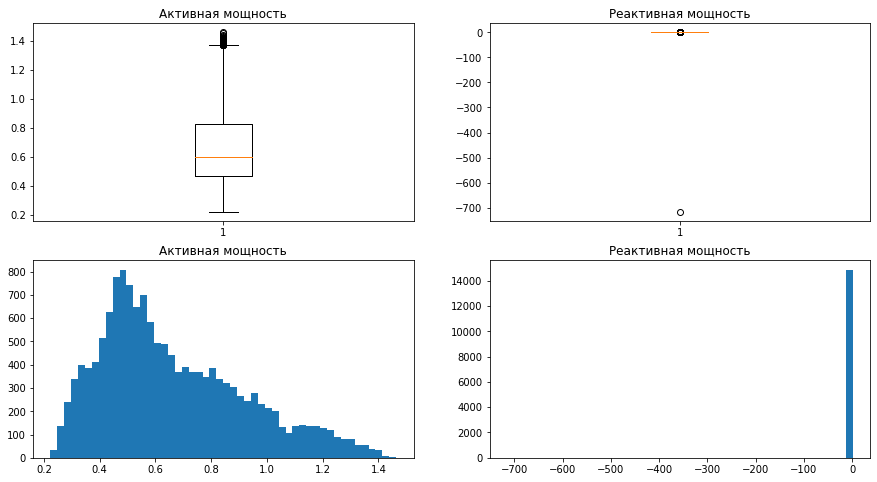

In [8]:
fig = plt.figure(figsize = (15, 8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.boxplot(data_arc['Активная мощность'])
ax1.set_title('Активная мощность')

ax2.boxplot(data_arc['Реактивная мощность'])
ax2.set_title('Реактивная мощность')

ax3.hist(data_arc['Активная мощность'], bins = 50)
ax3.set_title('Активная мощность')

ax4.hist(data_arc['Реактивная мощность'], bins = 50)
ax4.set_title('Реактивная мощность');

В данных о электродах нет пропусков, в данных о реактивной мощности есть выброс.

#### data_bulk (данные о подаче сыпучих материалов (объём))

In [9]:
df_basic_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


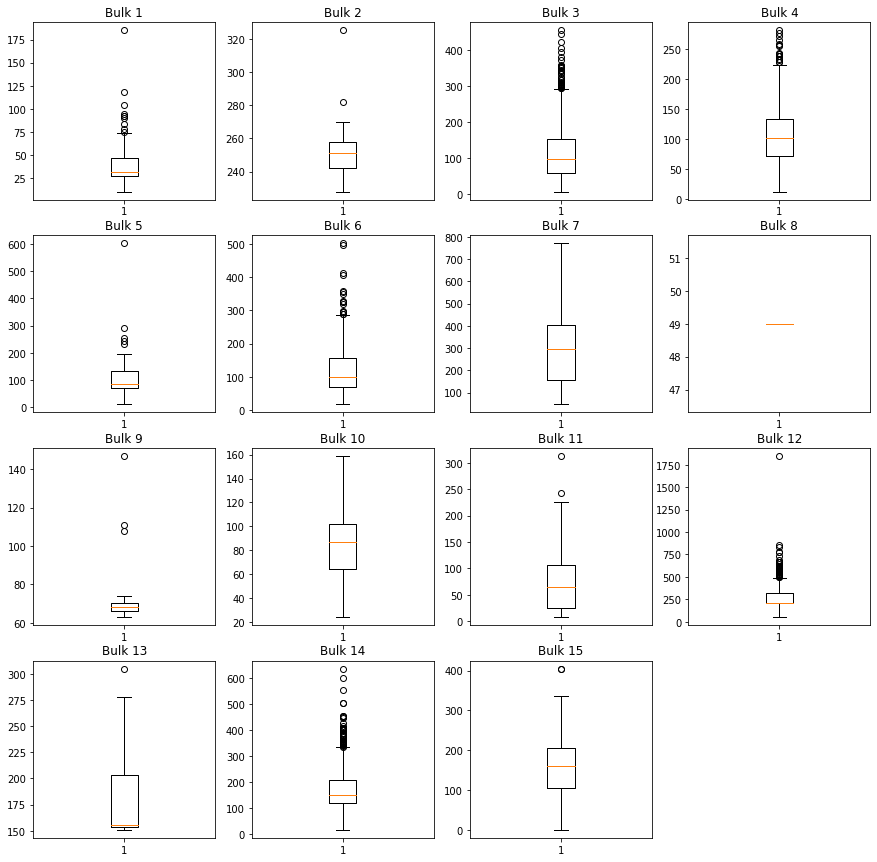

In [10]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(4, 4, 1)
ax2 = fig.add_subplot(4, 4, 2)
ax3 = fig.add_subplot(4, 4, 3)
ax4 = fig.add_subplot(4, 4, 4)
ax5 = fig.add_subplot(4, 4, 5)
ax6 = fig.add_subplot(4, 4, 6)
ax7 = fig.add_subplot(4, 4, 7)
ax8 = fig.add_subplot(4, 4, 8)
ax9 = fig.add_subplot(4, 4, 9)
ax10 = fig.add_subplot(4, 4, 10)
ax11 = fig.add_subplot(4, 4, 11)
ax12 = fig.add_subplot(4, 4, 12)
ax13 = fig.add_subplot(4, 4, 13)
ax14 = fig.add_subplot(4, 4, 14)
ax15 = fig.add_subplot(4, 4, 15)

ax1.boxplot(data_bulk['Bulk 1'].dropna())
ax1.set_title('Bulk 1')

ax2.boxplot(data_bulk['Bulk 2'].dropna())
ax2.set_title('Bulk 2')

ax3.boxplot(data_bulk['Bulk 3'].dropna())
ax3.set_title('Bulk 3')

ax4.boxplot(data_bulk['Bulk 4'].dropna())
ax4.set_title('Bulk 4')

ax5.boxplot(data_bulk['Bulk 5'].dropna())
ax5.set_title('Bulk 5')

ax6.boxplot(data_bulk['Bulk 6'].dropna())
ax6.set_title('Bulk 6')

ax7.boxplot(data_bulk['Bulk 7'].dropna())
ax7.set_title('Bulk 7')

ax8.boxplot(data_bulk['Bulk 8'].dropna())
ax8.set_title('Bulk 8')

ax9.boxplot(data_bulk['Bulk 9'].dropna())
ax9.set_title('Bulk 9')

ax10.boxplot(data_bulk['Bulk 10'].dropna())
ax10.set_title('Bulk 10')

ax11.boxplot(data_bulk['Bulk 11'].dropna())
ax11.set_title('Bulk 11')

ax12.boxplot(data_bulk['Bulk 12'].dropna())
ax12.set_title('Bulk 12')

ax13.boxplot(data_bulk['Bulk 13'].dropna())
ax13.set_title('Bulk 13')

ax14.boxplot(data_bulk['Bulk 14'].dropna())
ax14.set_title('Bulk 14')

ax15.boxplot(data_bulk['Bulk 15'].dropna())
ax15.set_title('Bulk 15');

Данные о сыпучих примесях выглядят адекватно. Есть "выбросы" в данных о применении некоторых примесей, но, думаю это особенность техпроцесса (рассказал подробнее ниже в выводе о исследовательском анализе). Бросается в глаза редкость применения некоторых примесей, особенно bulk_8 (1 раз). В данных много пропусков.

#### data_bulk_time (данные о подаче сыпучих материалов (время))

In [11]:
df_basic_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56


В данных о времени применения примесей много пропусков. Данные дополняют датасет с применением примесей.

#### data_gas (данные о продувке сплава газом)

In [12]:
df_basic_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


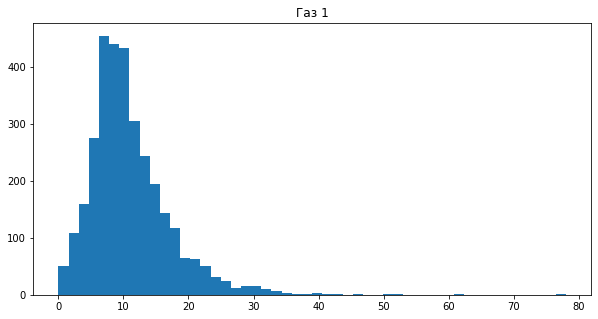

In [13]:
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 1, 1)

ax1.hist(data_gas['Газ 1'], bins = 50)
ax1.set_title('Газ 1');

Гистограмма применения продувочного газа выглядит адекватно, пропусков в данных нет.

#### data_temp (результаты измерения температуры)

In [14]:
df_basic_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


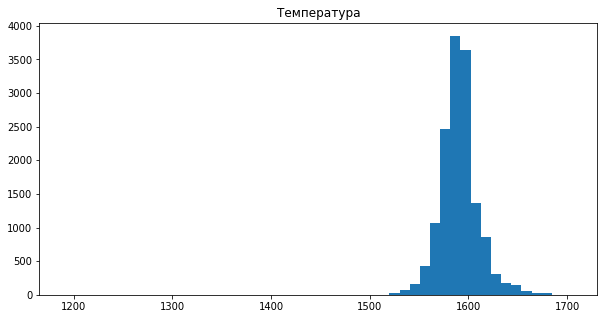

In [15]:
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 1, 1)

ax1.hist(data_temp['Температура'], bins = 50)
ax1.set_title('Температура');

In [16]:
data_temp.tail(20)

,key,Время замера,Температура
18072,3239,2019-09-06 14:22:49,NaN
18073,3239,2019-09-06 14:28:54,NaN
18074,3239,2019-09-06 14:33:34,NaN
18075,3239,2019-09-06 14:42:48,NaN
18076,3239,2019-09-06 14:56:58,NaN
18077,3239,2019-09-06 14:59:25,NaN
18078,3239,2019-09-06 15:03:35,NaN
18079,3239,2019-09-06 15:09:55,NaN
18080,3240,2019-09-06 15:25:21,1617.0
18081,3240,2019-09-06 15:30:52,NaN


Распределение температур выглядит адекватно, но есть результаты ниже 1500 (которые в дальнейшем будут убраны, потому что это ниже температуры плавления стали). Также если отобразить "хвост" датасета, будут видны партии, у которых есть только первое измерение температуры расплава. Такие партии не имеют целевого признака и будут убраны из данных в дальнейшем.

#### data_wire (данные о проволочных материалах (объём))

In [17]:
df_basic_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


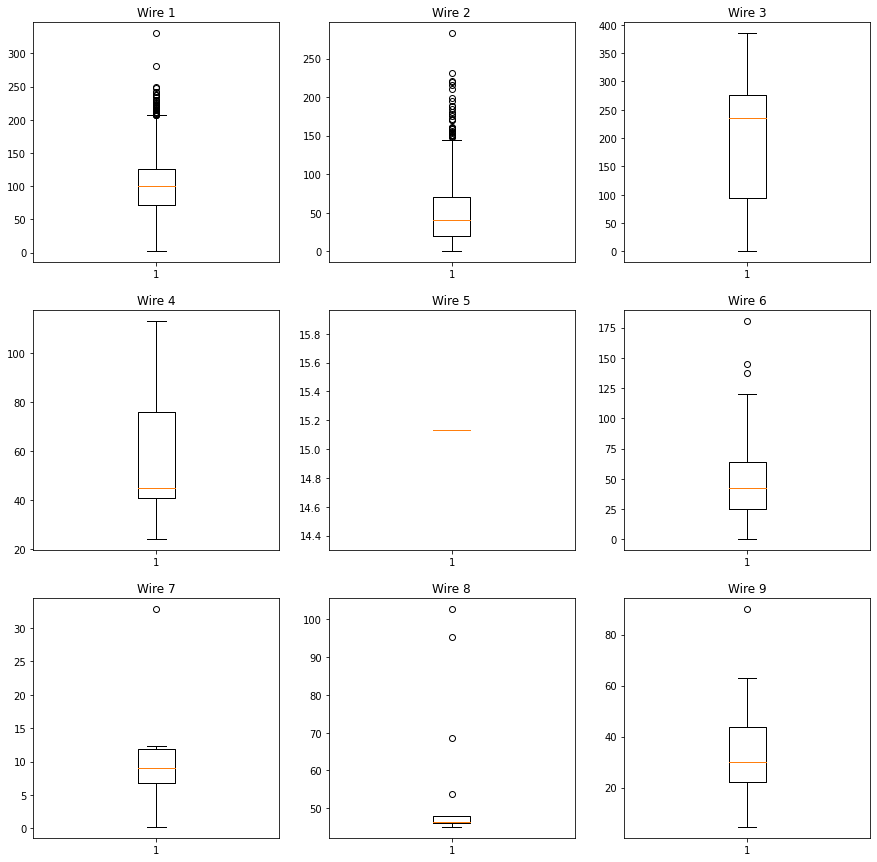

In [18]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)

ax1.boxplot(data_wire['Wire 1'].dropna())
ax1.set_title('Wire 1')

ax2.boxplot(data_wire['Wire 2'].dropna())
ax2.set_title('Wire 2')

ax3.boxplot(data_wire['Wire 3'].dropna())
ax3.set_title('Wire 3')

ax4.boxplot(data_wire['Wire 4'].dropna())
ax4.set_title('Wire 4')

ax5.boxplot(data_wire['Wire 5'].dropna())
ax5.set_title('Wire 5')

ax6.boxplot(data_wire['Wire 6'].dropna())
ax6.set_title('Wire 6')

ax7.boxplot(data_wire['Wire 7'].dropna())
ax7.set_title('Wire 7')

ax8.boxplot(data_wire['Wire 8'].dropna())
ax8.set_title('Wire 8')

ax9.boxplot(data_wire['Wire 9'].dropna())
ax9.set_title('Wire 9');

Картина аналогична данным из data_bulk о применении сыпучих примесей. Также много пропусков, также есть редко применяемые проволочные примеси.

#### data_wire_time (данные о проволочных материалах (время))

In [19]:
df_basic_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Картина аналогична данным о времени применения сыпучих примесей. Данные дополняют датасет с применением проволочных примесей, есть пропуски.

#### Выводы по исследовательскому анализу данных

Данные разделены не 7 датасетов, в которых хранится информация о разных частях техпроцесса обработки стали:
- данные о работе электродов (время начала и конца работы, активная и реактивная мощности);
- данные о подаче сыпучих материалов (предположительно массы/объемы сыпучих веществ);
- данные о времени подачи сыпучих веществ;
- данные о подаче газа (предположительно объем затраченного газа);
- данные о температуре сплава (судя по данным после каждой итерации добавления сыпучих/проволочных материалов в расплав);
- данные о температуре;
- данные о подаче проволочных материалов;
- данные о времени подачи проволочных материалов.

Был построен ряд коробчатых диаграмм и гистограмм по имеющимся данным.

На примере процесса с идентификатором key = 1 была разобрана (для общего понимания) хронология процессов, происходящих с расплавом:
- 11:02:04 - измерение темп. 1
- 11:02:14 - нач. нагрев 1
- 11:06:02 - кон. нагрев 1
- 11:06:19 - подача проволоки 1
- 11:07:18 - измерение темп. 2
- 11:07:28 - нач. нагрев 2
- 11:10:33 - кон. нагрев 2
- 11:10:43 - подача сыпучей примеси 15
- 11:11:34 - измерение темп. 3
- 11:11:44 - нач. нагрев 3
- 11:14:36 - кон. нагрев 3
- 11:14:50 - подача сыпучей примеси 14
- 11:18:04 - измерение темп. 4
- 11:18:14 - нач. нагрев 4
- 11:24:19 - кон. нагрев 4
- 11:24:31 - подача сыпучей примеси 12
- 11:25:59 - измерение темп. 5
- 11:26:09 - нач. нагрев 5
- 11:28:37 - кон. нагрев 5
- 11:28:48 - подача сыпучей примеси 4
- 11:30:38 - измерение темп. 6

То есть техпроцесс "опоясан" измерениями температуры (хим. состав в данных не фигурирует, поэтому его мы проигнорируем), в действительности процесс характеризуется суммой потраченных примесей и газа при десульфатации и легировании и температурой "сырого" и "готового" расплава. 

Также в данных был обнаружен выброс в столбце с данными о реактивной мощности. Остальные "выбросы" (если считать их таковыми на основании того, что выбросы это данные выбивающиеся более чем на 1.5 iqr от медианы) я выбросами не считаю, так как среди сплавов стали существуют марки, обладающие выдающимся количеством легирующих примесей или содержанием тех или иных компонентов. Примером здесь можно привести сталь ZDP-189, у которой 3% углерода, что по меркам стали не просто "выброс", а недопустимое значение без применения технологий порошковой металлургии (иначе она считалась бы чугуном). Проводить анализ на выбросы данных такого рода необходимо с глубочайшим погружением в доменную область, взаимодействием со специалистами в области материаловедения и расширением количества признаков для каждого расплава. Поэтому я считаю, что среди данных о введенных проволочных и сыпучих добавках выбросов нет.

### Список вопросов

1. Десульфатация и легирование это разные процедуры в процессе обработки стали. Наши данные из всех параметров расплава содержат только информацию о температуре. Исходные данные содержат информацию только о процессе десульфатации, только о процессе легирования или об обоих процессах последовательно (сначала десульфатация, потом легирование)?

2. Что за температуры представлены в data_temp_new? Не похоже на температуру плавления стали, она обычно немного ниже (около 1500 градусов), в данных же есть значения температуры около 1600 градусов.

3. Температуры в data_temp_new это температуры на начало или конец каждой итерации работы с расплавом? Вопрос тесно связан с первым вопросом. Как я понимаю все-таки на конец итерации.

4. Верно ли мое понимание техпроцесса обработки стали? В целом оно не противоречит хронологии процедур, которая разобрана выше.

Техпроцесс:

1) Взятие хим. пробы (в том числе **измерение температуры**) с расплава без добавления сыпучих и проволочных примесей;

2) Добавление десульфирующих примесей (если данные содержат информацию и о процессе десульфатации и о процессе легирования, то часть примесей должна быть десульфирующая, часть должна быть легирующая);

3) Взятие хим. пробы (в том числе **измерение температуры**) на содержание серы в расплаве. Если результаты неудовлетворительные, вернуться на п.2. Если результаты удовлетворительные, переход на следующий этап.

* Хим. проба и **проба температуры** из п.3 считается пробой, которая проводится перед добавлением легирующих добавок.

4) Повышение температуры расплава.

5) Добавление легирующих добавок.

6) Продувка инертным газом.

7) Перемешивание расплава.

8) Взятие хим. пробы (в том числе **измерение температуры**) на удовлетворение целевому хим. составу. Если результаты неудовлетворительные, вернуться на п.4. Если результаты удовлетворительные, переход на следующий этап.

9) Подача расплава в машину непрерывной разливки или отправка на доводку металла.

5. Верно ли я понял бизнес-задачу проекта?

6. Правильно ли я понимаю, что именно данными "о ковше" и о хим. составе металла я не могу пользоваться и они в задаче лишние?

### План решения задачи

**План**:

0) разобраться с вышеописанными вопросами;

1) предобработать данные (изменить названия столбов данных, произвести преобразование типов данных, объединить их в единый датафрейм, заполнить пропуски, убрать некоторые значения (если понадобится), сгруппировать данные о партиях металла используя данные только о начальной и конечной температуре);

2) подготовить данные к обучению (выделить целевой признак, разбить на обучающую, валидационную и тестовую выборки);

3) задаться целевой метрикой и ее значением (или сконцентрироваться просто на минимизации целевой метрики), скорее всего MSE или MAE;

4) обучить несколько моделей регрессии (скорее всего линейная регрессия, градиентный бустинг, может быть деревья), выделить лучшую модель;

5) провести тестирование лучшей модели

6) сделать выводы о проделанной работе

### Цель проекта

Разработать прототип модели машинного обучения, которая позволит сталелитейному заводу, зная количество газа и добавок, которые будут поданы в расплав, и температуру начального расплава, спрогнозировать температуру конечного расплава. 

P.S. Насколько я себе это вижу, бизнес-цель здесь в том, чтобы уйти от итеративности процесса добавления добавок или ослабить его влияние на время, необходимое для приготовления расплава с нужной характеристикой температуры (хим. состав на основе имеющихся данных мы использовать не можем). То есть речь идет об оптимизации производственного процесса. Меньше итераций и времени -> меньше нагрев -> меньше потребление электроэнергии.

## Решение задачи

### Изменение названий столбцов с данными

Названия столбцов с разным регистром и на разных языках. Привел данные в нижний регистр и перевел на английский.

In [20]:
col_names = {'Начало нагрева дугой' : 'heat_begin_time',
            'Конец нагрева дугой' : 'heat_end_time',
            'Активная мощность' : 'active_power',
            'Реактивная мощность' : 'reactive_power'}
data_arc = data_arc.rename(columns = col_names)

col_names = {'Bulk 1' : 'bulk_1',
            'Bulk 2' : 'bulk_2',
            'Bulk 3' : 'bulk_3',
            'Bulk 4' : 'bulk_4',
            'Bulk 5' : 'bulk_5',
            'Bulk 6' : 'bulk_6',
            'Bulk 7' : 'bulk_7',
            'Bulk 8' : 'bulk_8',
            'Bulk 9' : 'bulk_9',
            'Bulk 10' : 'bulk_10',
            'Bulk 11' : 'bulk_11',
            'Bulk 12' : 'bulk_12',
            'Bulk 13' : 'bulk_13',
            'Bulk 14' : 'bulk_14',
            'Bulk 15' : 'bulk_15',}
data_bulk = data_bulk.rename(columns = col_names)
data_bulk_time = data_bulk_time.rename(columns = col_names)

col_names = {'Газ 1' : 'gas_1'}
data_gas = data_gas.rename(columns = col_names)

col_names = {'Время замера' : 'temp_measure_time',
            'Температура' : 'temp'}
data_temp = data_temp.rename(columns = col_names)

col_names = {'Wire 1' : 'wire_1',
            'Wire 2' : 'wire_2',
            'Wire 3' : 'wire_3',
            'Wire 4' : 'wire_4',
            'Wire 5' : 'wire_5',
            'Wire 6' : 'wire_6',
            'Wire 7' : 'wire_7',
            'Wire 8' : 'wire_8',
            'Wire 9' : 'wire_9',
            }
data_wire = data_wire.rename(columns = col_names)
data_wire_time = data_wire_time.rename(columns = col_names)

### Группировка data_arc

Из данных о работе электродов я взял суммы мощностей по партии и вычислил время нагрева.

In [21]:
data_arc['heat_time'] = data_arc['heat_end_time'] - data_arc['heat_begin_time']
data_arc_grouped = data_arc.groupby(by = 'key').agg({'active_power' : 'sum', 
                                 'reactive_power' : 'sum',
                                 'heat_time' : 'sum'})
data_arc_grouped = data_arc_grouped.reset_index()

display(data_arc_grouped.head())
data_arc_grouped.info()

,key,active_power,reactive_power,heat_time
0,1,3.036730,2.142821,0 days 00:18:18
1,2,2.139408,1.453357,0 days 00:13:31
2,3,4.063641,2.937457,0 days 00:10:55
3,4,2.706489,2.056992,0 days 00:12:21
4,5,2.252950,1.687991,0 days 00:14:29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   key             3214 non-null   int64          
 1   active_power    3214 non-null   float64        
 2   reactive_power  3214 non-null   float64        
 3   heat_time       3214 non-null   timedelta64[ns]
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 100.6 KB


### Группировка data_temp

Из данных о температуре расплава я взял первое и последнее измерение температуры. Особенность такой аггрегации в том, что если попадается партия у которой нет конечной температуры (о таком было написано выше), последняя и первая температура в группированном датасете будет одинаковой, это необходимо учитывать.

In [22]:
data_temp_grouped = data_temp.groupby(by = 'key').agg({'temp' : ['first', 'last','count']})
data_temp_grouped.columns = ['first_temp', 'last_temp','temp_count']
data_temp_grouped = data_temp_grouped.reset_index()


display(data_temp_grouped.head())
data_temp_grouped.info()

,key,first_temp,last_temp,temp_count
0,1,1571.0,1613.0,6
1,2,1581.0,1602.0,5
2,3,1596.0,1599.0,6
3,4,1601.0,1625.0,5
4,5,1576.0,1602.0,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3216 non-null   int64  
 1   first_temp  3216 non-null   float64
 2   last_temp   3216 non-null   float64
 3   temp_count  3216 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 100.6 KB


In [23]:
# к.р.
data_temp_grouped.describe()

,key,first_temp,last_temp,temp_count
count,3216.000000,3216.000000,3216.000000,3216.000000
mean,1622.199316,1588.592040,1593.928483,4.560012
std,935.088523,29.137454,19.874627,2.406343
min,1.000000,1191.000000,1204.000000,1.000000
25%,815.750000,1572.000000,1585.000000,3.000000
50%,1622.500000,1588.000000,1593.000000,5.000000
75%,2431.250000,1606.000000,1600.000000,6.000000
max,3241.000000,1684.000000,1700.000000,17.000000


### Объединение датафреймов

Здесь объединяются группированные датасеты о температуре и нагреве с остальными данными. Данные о времени применения проволочных и сыпучих примесей не добавляются. Объединение велось по ключу, пропуски в данных будут после объединения только в данных о примесях и газе, заполнил их нулями (не применяется).

In [24]:
data = pd.merge(data_temp_grouped, data_arc_grouped, on = 'key')
data = pd.merge(data, data_gas, on = 'key')
data = pd.merge(data, data_bulk.fillna(0), on = 'key')
data = pd.merge(data, data_wire.fillna(0), on = 'key')

data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3022 entries, 0 to 3021
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   key             3022 non-null   int64          
 1   first_temp      3022 non-null   float64        
 2   last_temp       3022 non-null   float64        
 3   temp_count      3022 non-null   int64          
 4   active_power    3022 non-null   float64        
 5   reactive_power  3022 non-null   float64        
 6   heat_time       3022 non-null   timedelta64[ns]
 7   gas_1           3022 non-null   float64        
 8   bulk_1          3022 non-null   float64        
 9   bulk_2          3022 non-null   float64        
 10  bulk_3          3022 non-null   float64        
 11  bulk_4          3022 non-null   float64        
 12  bulk_5          3022 non-null   float64        
 13  bulk_6          3022 non-null   float64        
 14  bulk_7          3022 non-null   float64 

,key,first_temp,last_temp,temp_count,active_power,reactive_power,heat_time,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,6,3.036730,2.142821,0 days 00:18:18,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,5,2.139408,1.453357,0 days 00:13:31,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,6,4.063641,2.937457,0 days 00:10:55,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,5,2.706489,2.056992,0 days 00:12:21,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,5,2.252950,1.687991,0 days 00:14:29,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Добавление признаков

Добавил признаки полной мощности (по формуле полной мощности, где мощность это корень из суммы квадратов активной и реактивной мощностей), добавил признак с суммой сыпучих и суммой проволочных примесей (необходимы будут для фильтрации данных).

In [25]:
data['total_power'] = np.sqrt(
    data['active_power'] ** 2 + data['reactive_power'] ** 2)

cols = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 
        'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data['bulk_sum'] = data[list(cols)].sum(axis=1)

cols = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 
        'wire_6', 'wire_7', 'wire_8', 'wire_9']
data['wire_sum'] = data[list(cols)].sum(axis=1)

### Проверка исключений

Под исключениями здесь понимаются заведомо некорректные данные. Здесь ведется проверка количества некорректных партий по следующим критериям:
- не применялись сыпучие примеси (не произошла десульфурация);
- не применялись проволочные примеси (не произошло легирование);
- первое измерение температуры показало ниже 1500 (сталь не представляет из себя расплав при данной температуре);
- последнее измерение температуры показало ниже 1500 (аналогично пункту выше);
- отрицательная реактивная мощность;
- первая и последняя температура расплава одинаковы (партии, где измерение температуры было только одно (первое), проверка через равенство ведется из-за применения функции аггрегации температур, об этом написано выше).

In [26]:
print('Партий без сыпучих примесей:', 
      data.loc[data['bulk_sum'] == 0].shape[0])
print('Партий без проволочных примесей:', 
      data.loc[data['wire_sum'] == 0].shape[0])
print('Партий с начальной температурой менее 1500:', 
      data.loc[data['first_temp'] < 1500].shape[0])
print('Партий с конечной температурой менее 1500:', 
      data.loc[data['last_temp'] < 1500].shape[0])
print('Партий с отрицательной реактивной мощностью:', 
      data.loc[data['reactive_power'] < 0].shape[0])
print('Партий с без изменений температуры в процессе обработки:', 
      data.loc[data['first_temp'] == data['last_temp']].shape[0])

Партий без сыпучих примесей: 0
Партий без проволочных примесей: 0
Партий с начальной температурой менее 1500: 5
Партий с конечной температурой менее 1500: 1
Партий с отрицательной реактивной мощностью: 1
Партий с без изменений температуры в процессе обработки: 729


In [27]:
data.describe()

,key,first_temp,last_temp,temp_count,active_power,reactive_power,heat_time,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,total_power,bulk_sum,wire_sum
count,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000
mean,1623.313038,1586.772005,1591.894441,4.618795,3.115255,2.052996,0 days 00:13:21.683322303,11.302433,3.272336,1.842158,48.719060,34.930510,2.727002,22.449371,2.512574,0.016214,0.479815,4.850430,4.499338,203.355394,1.078756,153.076109,118.701853,100.306762,17.555999,3.950168,0.266115,0.005007,1.159907,0.036542,0.337154,0.246959,4.102485,602.510920,123.864613
std,931.884924,28.104700,16.644832,2.426329,1.206619,13.059864,0 days 00:05:31.577569887,6.233396,12.062357,21.587675,74.954261,56.570091,21.279385,56.149242,32.491442,0.891351,6.261812,20.491563,23.083083,152.247677,14.360646,80.860873,83.389774,42.746214,33.306307,30.600083,4.335435,0.275264,9.043740,0.781697,4.435119,3.040308,13.004008,276.437768,65.868919
min,1.000000,1191.000000,1204.000000,1.000000,0.267676,-713.966032,0 days 00:00:57,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.331897,19.000000,1.918800
25%,821.250000,1571.000000,1585.000000,3.000000,2.290557,1.668253,0 days 00:09:36.500000,7.281707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,71.436301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.829590,440.250000,86.603403
50%,1618.500000,1587.000000,1592.000000,5.000000,3.023124,2.215952,0 days 00:12:56,10.016304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,100.151993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.750963,597.000000,114.192002
75%,2429.750000,1603.000000,1599.000000,6.000000,3.831626,2.818183,0 days 00:16:27,14.077546,0.000000,0.000000,82.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,125.863920,23.159760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.766217,779.000000,150.191339
max,3241.000000,1660.000000,1653.000000,17.000000,12.375636,8.949049,0 days 01:09:49,77.995040,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,62.025600,713.970901,3235.000000,663.851766


### Разделение на обучающую и тестовую выборки

Разделение данных на выборки с соотношением 75 к 25.

In [28]:
data_train, data_test = train_test_split(data, test_size = 0.25, random_state = random_state)

In [29]:
print('Размер обучающей выборки:', data_train.shape[0])
print('Размер тестовой выборки:', data_test.shape[0])

Размер обучающей выборки: 2266
Размер тестовой выборки: 756


### Очистка данных обучающей выборки

#### Удаление некорректных данных

Удалил из обучающих данных некорректные, по критериям описанным выше. Из тестовых удалил только данные, которые не содержат целевого признака (конечной температуры).

data_train = data_train.loc[(data_train['first_temp'] >= 1500) & 
                            (data_train['last_temp'] >= 1500) & 
                            (data_train['reactive_power'] > 0) & 
                            (data_train['temp_count'] > 1)]

data_test = data_test.loc[(data_test['first_temp'] != data_test['last_temp'])]

print('Размер обучающей после очистки выборки:', data_train.shape[0])

In [30]:
data_train = data_train.loc[(data_train['first_temp'] >= 1500) & 
                            (data_train['last_temp'] >= 1500) & 
                            (data_train['reactive_power'] > 0) & 
                            (data_train['temp_count'] > 1)]

data_test = data_test.loc[(data_test['temp_count'] > 1) & (data_test['first_temp'] >= 1500) &(data_test['last_temp'] >= 1500)&(data_test['reactive_power'] > 0)]

print('Размер обучающей после очистки выборки:', data_train.shape[0])
print('Размер тестовой после очистки выборки:', data_test.shape[0])

Размер обучающей после очистки выборки: 1768
Размер тестовой после очистки выборки: 556


#### Борьба с мультиколлинеарностью

Мультиколлинеарность - высокий коэффициент корреляции между признаками. Без борьбы с мультиколлинеарностью методы машинного обучения (например линейная регрессия) могут обучаться некорректно (с чем я столкнулся). Борьба с мультиколлинеарностью в этом проекте ведется посредством удаления одного пары корреклирующих признаков. Удалялся признак с коэффициентом корреляции выше 0.7. Построены соответствующие тепловые карты. Также на первой тепловой карте можно заметить "белые полосы", они соответствуют признаку, который полностью утратил данные в процессе фильтрации данных.

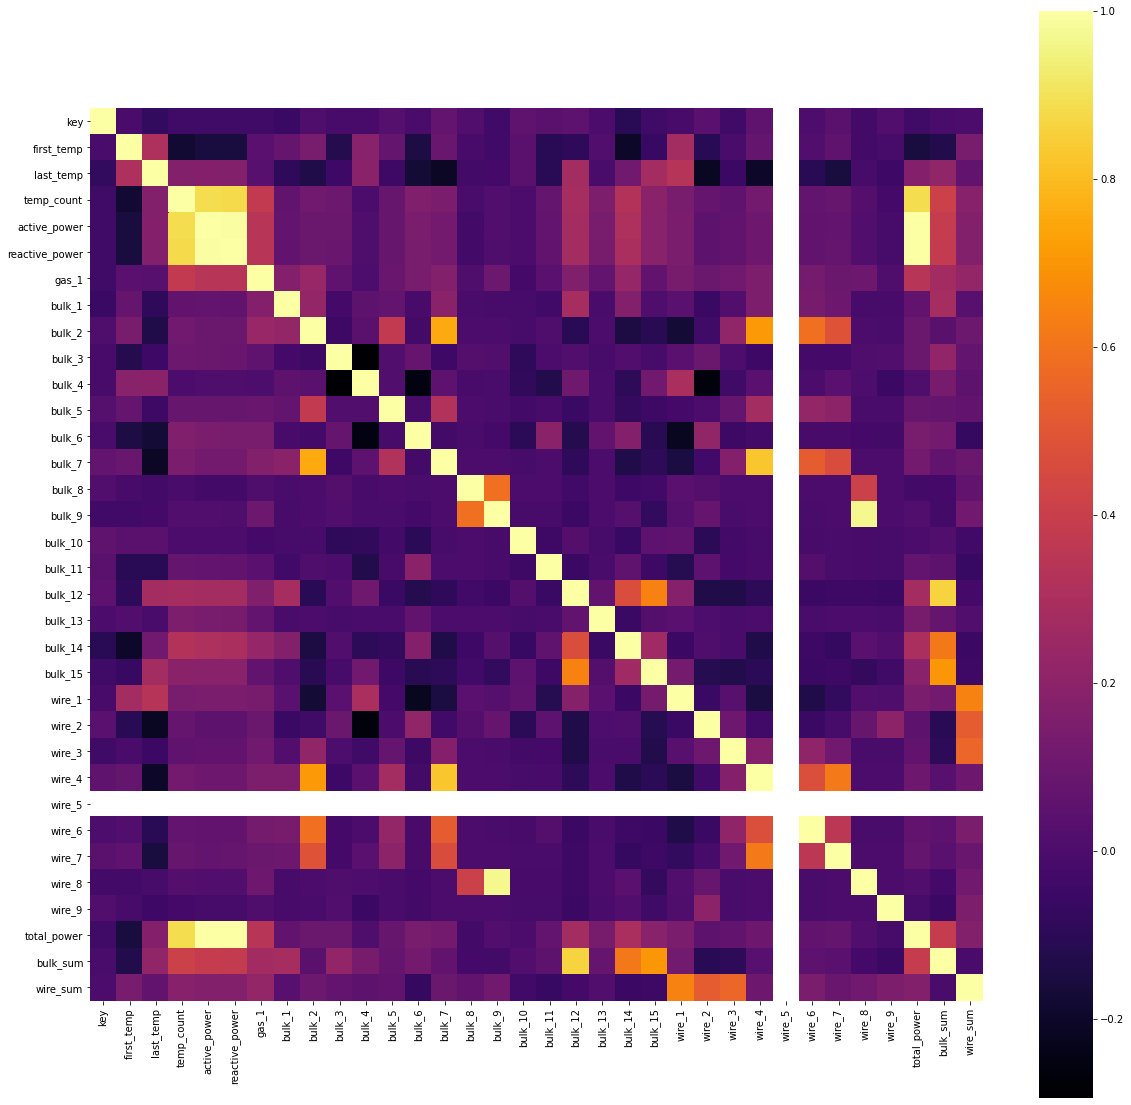

In [31]:
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(111)

ax1 = sns.heatmap(data = data_train.corr(), 
                  square = True, 
                  cmap = 'inferno', 
                  annot = False)

In [32]:
drop_columns = ['key', 'total_power', 'reactive_power', 'heat_time', 'temp_count', 
                'bulk_2', 'bulk_7', 'wire_5', 'wire_8', 
                'bulk_sum', 'wire_sum']
data_train = data_train.drop(drop_columns, axis = 1)
data_test = data_test.drop(drop_columns, axis = 1)

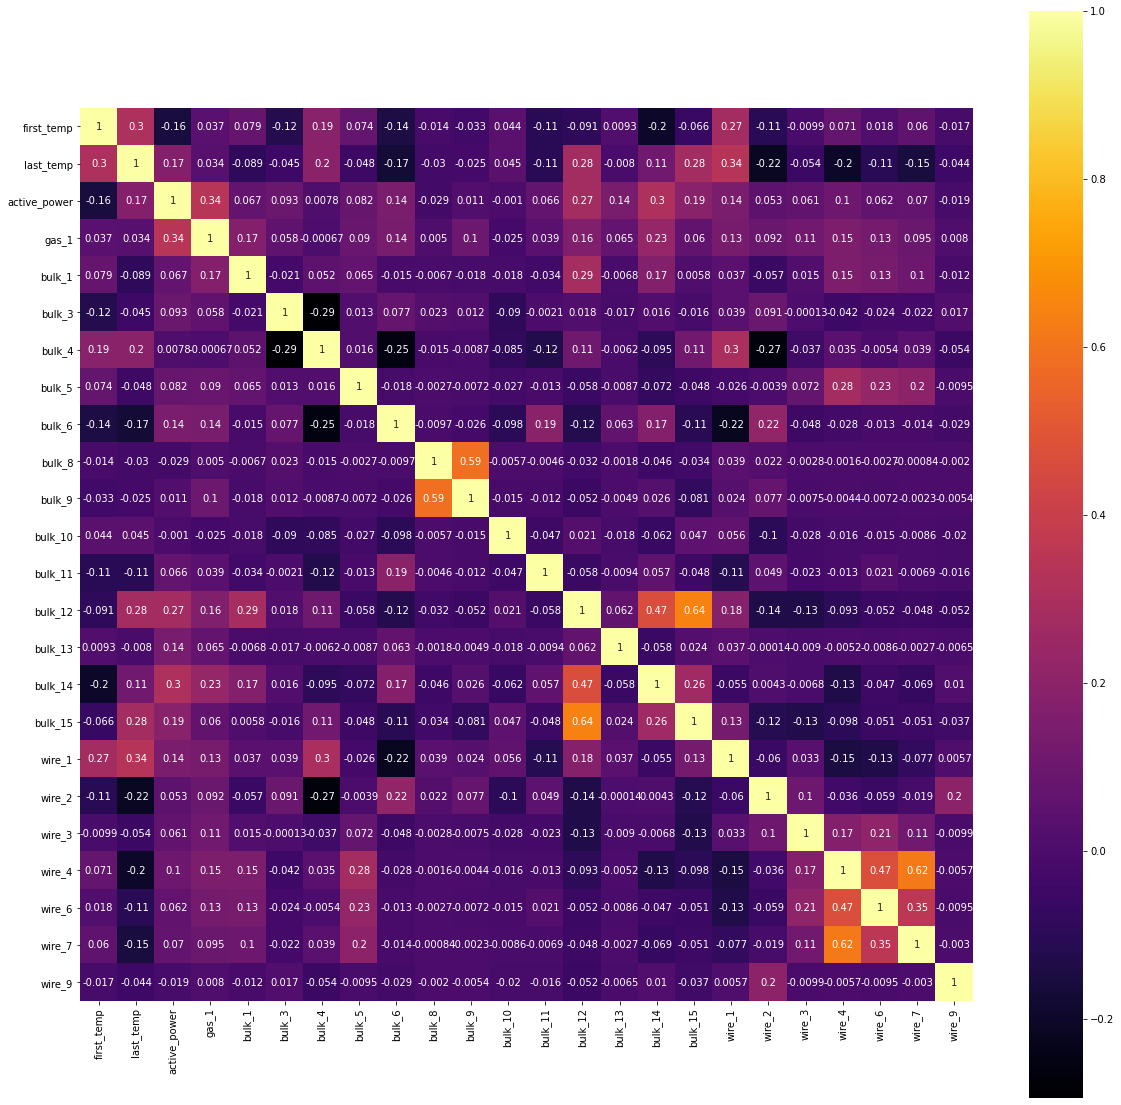

In [33]:
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(111)

ax1 = sns.heatmap(data = data_train.corr(), 
                  square = True, 
                  cmap = 'inferno', 
                  annot = True)

### Разделение данных на features и target

Отделение целевого признака от остальных.

In [34]:
data_train_features = data_train.drop(['last_temp'], axis = 1)
data_train_target = data_train['last_temp']
data_test_features = data_test.drop(['last_temp'], axis = 1)
data_test_target = data_test['last_temp']

Основная информация о полученных датасетах.

In [35]:
data_train_features.info()
data_train_target.info()
data_test_features.info()
data_test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768 entries, 174 to 1884
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    1768 non-null   float64
 1   active_power  1768 non-null   float64
 2   gas_1         1768 non-null   float64
 3   bulk_1        1768 non-null   float64
 4   bulk_3        1768 non-null   float64
 5   bulk_4        1768 non-null   float64
 6   bulk_5        1768 non-null   float64
 7   bulk_6        1768 non-null   float64
 8   bulk_8        1768 non-null   float64
 9   bulk_9        1768 non-null   float64
 10  bulk_10       1768 non-null   float64
 11  bulk_11       1768 non-null   float64
 12  bulk_12       1768 non-null   float64
 13  bulk_13       1768 non-null   float64
 14  bulk_14       1768 non-null   float64
 15  bulk_15       1768 non-null   float64
 16  wire_1        1768 non-null   float64
 17  wire_2        1768 non-null   float64
 18  wire_3        1768 non-nul

AttributeError: 'Series' object has no attribute 'info'

### Обучение моделей

Функция для скоринга моделей.

In [39]:
def MAE(target, predict):
    mae = mean_absolute_error(target, predict)
    return mae

#### Linear Regressor

In [36]:
%%time

model_linear_regression = LinearRegression()
CV_linear_regression = cross_val_score(model_linear_regression, 
                                       data_train_features, 
                                       data_train_target, 
                                       cv = 5, scoring = 'neg_mean_absolute_error')

print('MAE =', -CV_linear_regression.mean())

MAE = 7.122414146594148
CPU times: user 105 ms, sys: 120 ms, total: 225 ms
Wall time: 177 ms


In [37]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(data_train_features, data_train_target)

LinearRegression()

In [40]:
data_test_predict = model_linear_regression.predict(data_test_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\nMAE = ', round(MAE(data_test_target, data_test_predict), 3))

Метрики наилучшей модели из исследованных:

MAE =  6.647


#### Catboost

In [41]:
%%time
catboost_grid_space = {
    'depth' : [2, 4, 8, 12], 
    'iterations' : [40, 60, 80, 100, 200, 500]
}

model = CatBoostRegressor()

MAE_score = make_scorer(MAE, greater_is_better = False)

grid = GridSearchCV(estimator = model, param_grid = catboost_grid_space, cv = 5, scoring = MAE_score)
model_grid = grid.fit(data_train_features, data_train_target, verbose = None)

print('Лучшие гиперпараметры:', model_grid.best_params_)
print('Лучшая оценка:', abs(model_grid.best_score_))

Learning rate set to 0.5
0:	learn: 11.0137338	total: 46.9ms	remaining: 1.83s
1:	learn: 10.6212437	total: 47.8ms	remaining: 908ms
2:	learn: 10.3235140	total: 48.4ms	remaining: 597ms
3:	learn: 10.1290671	total: 49.4ms	remaining: 444ms
4:	learn: 10.0044100	total: 50ms	remaining: 350ms
5:	learn: 9.9017394	total: 50.7ms	remaining: 287ms
6:	learn: 9.8288928	total: 51.3ms	remaining: 242ms
7:	learn: 9.7477112	total: 51.9ms	remaining: 208ms
8:	learn: 9.6602750	total: 52.8ms	remaining: 182ms
9:	learn: 9.5577586	total: 53.6ms	remaining: 161ms
10:	learn: 9.4480846	total: 54.5ms	remaining: 144ms
11:	learn: 9.3044345	total: 55.3ms	remaining: 129ms
12:	learn: 9.2612871	total: 56.1ms	remaining: 117ms
13:	learn: 9.2025134	total: 56.9ms	remaining: 106ms
14:	learn: 9.1141852	total: 57.8ms	remaining: 96.4ms
15:	learn: 9.0562912	total: 58.6ms	remaining: 87.9ms
16:	learn: 9.0082964	total: 59.4ms	remaining: 80.4ms
17:	learn: 8.9681631	total: 60.3ms	remaining: 73.7ms
18:	learn: 8.9325257	total: 61.1ms	remaini

In [42]:
%%time

model_catboost = CatBoostRegressor(
    iterations = int(model_grid.best_params_['iterations']), 
    depth = int(model_grid.best_params_['depth']),
    learning_rate = None)
model_catboost.fit(data_train_features, data_train_target)
data_test_predict = model_catboost.predict(data_test_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\n MAE = ', round(MAE(data_test_target, data_test_predict), 3))

Learning rate set to 0.165785
0:	learn: 11.2775195	total: 1.44ms	remaining: 286ms
1:	learn: 11.0731326	total: 2.68ms	remaining: 265ms
2:	learn: 10.8796280	total: 3.61ms	remaining: 237ms
3:	learn: 10.7521877	total: 4.75ms	remaining: 233ms
4:	learn: 10.6452820	total: 5.77ms	remaining: 225ms
5:	learn: 10.5210058	total: 6.73ms	remaining: 218ms
6:	learn: 10.4279603	total: 7.49ms	remaining: 207ms
7:	learn: 10.3504069	total: 8.29ms	remaining: 199ms
8:	learn: 10.2649724	total: 9.09ms	remaining: 193ms
9:	learn: 10.1667602	total: 10.1ms	remaining: 191ms
10:	learn: 10.1002461	total: 10.9ms	remaining: 188ms
11:	learn: 10.0371111	total: 11.9ms	remaining: 187ms
12:	learn: 9.9487520	total: 12.7ms	remaining: 182ms
13:	learn: 9.8998955	total: 13.5ms	remaining: 180ms
14:	learn: 9.8524155	total: 14.6ms	remaining: 181ms
15:	learn: 9.8011020	total: 15.7ms	remaining: 181ms
16:	learn: 9.7520594	total: 16.9ms	remaining: 182ms
17:	learn: 9.7005799	total: 18.1ms	remaining: 183ms
18:	learn: 9.6511333	total: 19.2

#### Random Forest Regressor

In [43]:
%%time
random_forest_grid_space = {
    'max_depth' : [8, 10, 15], 
    'n_estimators' : [500, 750, 1000],
    'min_samples_split' : [20, 30, 40]
}

model = RandomForestRegressor(random_state = random_state)

MAE_score = make_scorer(MAE, greater_is_better = False)

grid = GridSearchCV(estimator = model, param_grid = random_forest_grid_space, cv = 5, scoring = MAE_score)
model_grid = grid.fit(data_train_features, data_train_target)

print('Лучшие гиперпараметры:', model_grid.best_params_)
print('Лучшая оценка:', abs(model_grid.best_score_))

Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 750}
Лучшая оценка: 7.1646306687297905
CPU times: user 9min 39s, sys: 5.2 s, total: 9min 44s
Wall time: 9min 47s


In [44]:
%%time

model_random_forest = RandomForestRegressor(max_depth = int(model_grid.best_params_['max_depth']), 
                                            n_estimators = int(model_grid.best_params_['n_estimators']),
                                            min_samples_split = int(model_grid.best_params_['min_samples_split']), 
                                            random_state = random_state)
model_random_forest.fit(data_train_features, data_train_target)

CPU times: user 5.2 s, sys: 23.9 ms, total: 5.23 s
Wall time: 5.27 s


RandomForestRegressor(max_depth=10, min_samples_split=30, n_estimators=750,
                      random_state=240423)

In [45]:
data_test_predict = model_random_forest.predict(data_test_features)

print('Метрики наилучшей модели из исследованных:')                        
print('\nMAE = ', round(MAE(data_test_target, data_test_predict), 3))

Метрики наилучшей модели из исследованных:

MAE =  6.403


### Результаты обучения моделей 

|  |Linear Regression|CatBoost|Random Forest Regressor|
|:-|:-:|:-:|:-:|
|MAE на валидационной выборке|7.123|7.084|7.165|
|MAE на тестовой выборке|6.647|6.496|**6.403**|
|MAE < 6.8|+|+|+|

Наилучшая модель - RandomForestRegressor с гиперпараметрами:
- max_depth=10, 
- min_samples_split=30, 
- n_estimators=750,
- random_state=240423.

МАЕ на тестовой выборке наилучшей модели МАЕ = 6.403.

"Важность" признаков при обучении наилучшей модели:


first_temp      0.194229
wire_1          0.164264
bulk_12         0.102998
active_power    0.081392
bulk_15         0.074455
wire_2          0.068815
bulk_14         0.068257
bulk_6          0.052289
gas_1           0.049398
wire_4          0.042790
bulk_1          0.025624
wire_6          0.015206
bulk_4          0.013746
wire_7          0.013725
bulk_3          0.011762
bulk_11         0.006093
bulk_5          0.005188
wire_3          0.004765
bulk_10         0.003482
bulk_13         0.001313
wire_9          0.000141
bulk_9          0.000056
bulk_8          0.000011
dtype: float64

Text(0.5, 1.0, 'Важность признаков для наилучшей модели')

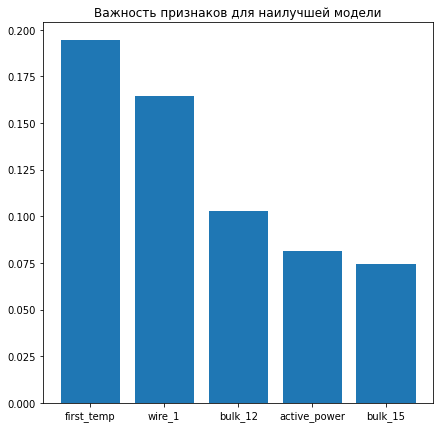

In [46]:
feature_importances = pd.Series(data = model_random_forest.feature_importances_, 
                                   index = data_test_features.columns)
print('"Важность" признаков при обучении наилучшей модели:')
display(feature_importances.sort_values(ascending = False))

feature_importances_top_5 = feature_importances.sort_values(ascending = False).head(5)

fig = plt.figure(figsize = (7, 7))
ax1 = fig.add_subplot(111)
ax2.set_title('Тип топлива')
ax1.bar(feature_importances_top_5.index, feature_importances_top_5)
ax1.set_title('Важность признаков для наилучшей модели')

### Выводы

В данной работе исследованию и разработке прототипов моделей машинного обучения были подвергнуты данные о выплавке стали. 

Данные разделены не 7 датасетов, в которых хранится информация о разных частях техпроцесса обработки стали:
- данные о работе электродов (время начала и конца работы, активная и реактивная мощности);
- данные о подаче сыпучих материалов (предположительно массы/объемы сыпучих веществ);
- данные о времени подачи сыпучих веществ;
- данные о подаче газа (предположительно объем затраченного газа);
- данные о температуре сплава (судя по данным после каждой итерации добавления сыпучих/проволочных материалов в расплав);
- данные о температуре;
- данные о подаче проволочных материалов;
- данные о времени подачи проволочных материалов.

Данные имеют большое количество пропусков, как в данных о примесях, так и в данных о температуре. Убраны данные не имеющие целевого признака (последней температуры), имеющие температуру менее 1500 градусов (ниже температуры плавления стали), данные в которых не происходила десульфурация или легирование. 

Проведена борьба с мультиколлинеарностью посредством удаления одного из пары признаков с высоким коэффициентом корреляции (более 0.7).

Бизнес-цель проекта в том, чтобы уйти от итеративности процесса добавления добавок или ослабить его влияние на время, необходимое для приготовления расплава с нужной характеристикой температуры (хим. состав на основе имеющихся данных мы использовать не можем). То есть речь идет об оптимизации производственного процесса. Меньше итераций и времени -> меньше нагрев -> меньше потребление электроэнергии.

Обучены три типа моделей машинного обучения:
- LinearRegression;
- CatBoost;
- RandomForestRegressor.

Наилучшая модель - RandomForestRegressor с гиперпараметрами:
- max_depth = 10, 
- min_samples_split = 30, 
- n_estimators = 750,
- random_state = 240423.

МАЕ на тестовой выборке наилучшей модели МАЕ = 6.403.

Наиболее "важными" признаками при обучении наилучшей модели стали:
- first_temp;
- wire_1;
- bulk_12;
- active_power;
- bulk_15.

## Отчет о проделанной работе

### Список вопросов

1) Какие пункты плана были выполнены, а какие - нет. Почему?

2) Какие трудности возникли и как вы их преодолели?

3) Какие ключевые шаги в решении задачи вы выделили?

4) Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

5) Какая ваша итоговая модель, какие у нее гиперпараметры и какое качество?

### Цель проекта

Разработать прототип модели машинного обучения, которая позволит сталелитейному заводу, зная количество газа и добавок, которые будут поданы в расплав, и температуру начального расплава, спрогнозировать температуру конечного расплава. 

### Выполненные и не выполненные пункты плана

Для данной работы был выведен следующий план:

1) предобработать данные (изменить названия столбов данных, произвести преобразование типов данных, объединить их в единый датафрейм, заполнить пропуски, убрать некоторые значения (если понадобится), сгруппировать данные о партиях металла используя данные только о начальной и конечной температуре);

2) подготовить данные к обучению (выделить целевой признак, разбить на обучающую, валидационную и тестовую выборки);

3) задаться целевой метрикой и ее значением (или сконцентрироваться просто на минимизации целевой метрики), скорее всего MSE или MAE;

4) обучить несколько моделей регрессии (скорее всего линейная регрессия, градиентный бустинг, может быть деревья), выделить лучшую модель;

5) провести тестирование лучшей модели

6) сделать выводы о проделанной работе

В ходе работы названия всех столбцов данных были переведены на английский язык и приведены в "змеиный регистр". Преобразование типов понадобилось только для данных о дате и времени работы электродов, добавления примесей и проведения измерений температуры. Данные о дате и времени переведены в тип datetime. Для объединения данных в единый датафрейм сначала необходимо было провести аггрегацию данных о работе электродов и измерениях температуры. Данные были аггрегированы по партиям, мощность на электродах была суммирована, из температур выделены первое и последнее измерение, а также посчитано количество измерений (для дальнейшей обработки данных). Были убраны партии, где представлено только одно измерение температуры, партии без добавления примесей и партии с температурой (начальной или конечной ниже 1500 град.). Пропуски в итоговом датафрейме были только в данных о добавлении примесей и были заполнены нулями.

Целевой признак в данной работе - конечная температура расплава (последнее измерение температуры). Данные разделены на обучающую и тестовую выборку в соотношении 75/25 (разделение происходило до очистки данных). Random state при разделени был зафиксирован значением 240423.

Метрика была задана в процессе взаимодействия с тимлидом. Модели сравнивались по средней абсолютной ошибке (MAE), для успешного выполнения задачи модель должна была показать MAE < 6.8 на тестовой выборке.

В процессе выполнения работы были обучены три модели машинного обучения:
- Linear Regression;
- Catboost Regressor;
- Random Forest Regressor.

Все модели протестированы, при поиске гиперпараметров и обучении применялась кросс-валидация.

Сделаны выводы о проделанной работе.

В целом, все пункты плана выполнены. Отдельно стоит сказать, что в плане не указано масштабирование признаков, которое в итоге не было применено из-за слабого влияния на конечный результат (проверка влияния масштабирования признаков в работе велась, но в финальный код решения это не вошло). Также в плане не указано о борьбе с мультиколлинеарностью. В данной работе борьба с мультиколлинеарностью велась посредством удаления одного из двух признаков с высоким коэффициентом корреляции (более 0.7).

### Трудности и их преодоление

В общем и целом, особых трудностей в выполнении работы не возникло. Единственное, что можно отметить, в плане решения не было борьбы с мультиколлинеарностью признаков. Поэтому в черновом варианте решения не получалось достигнуть хоть каких-то результатов при обучении линейной регрессии. Линейная регрессия чувствительна к мультиколлинеарности, поэтому обучить ее получилось только после удаления некоторых признаков. MAE остальных моделей после удаления коррелирующих признаков уменьшилось.

### Ключевые шаги в решении задачи

Данная задача отмечена мной как чувствительная к хотя бы минимальному пониманию доменной области (алгоритма процесса выплавки стали), если сравнивать с другими проектами в рамках курса. Поэтому я выделил следующие шаги в решении задачи:
- "гуглинг" и поверхностное вникание в процесс выплавки стали;
- исследовательский анализ данных, построение графиков и выделение основных статистических показателей;
- подробный разбор таймлайна техпроцесса выплавки стали на примере одной из партий в датасете;
- аггрегация данных о температуре и работе электродов;
- "сборка" полного датасета в одном датафрейме;
- предобработка данных;
- обучение и тестирование моделей;
- анализ важности признаков;
- написание выводов о проделанной работе.

### Признаки, использованные для обучения, и их предобработка

Исходные данные содержат в себе следующие признаки:
- время включения, время отключения, активная мощность и реактивная мощность электродов;
- количество примененной сыпучей примеси (15-ти примесей);
- время применения сыпучей примеси (для 15-ти примесей);
- количество примененного продувочного газа;
- количество примененной проволочной примеси (9-ти примесей);
- время применения проволочной примеси (для 9-ти примесей);
- данные о времени проведения измерения и самом измерении температуры;
- идентификатор партии (для всех датасетов).

В процессе обработки данных были выведены еще несколько признаков:
- общая мощность на электроде (квадратный корень из суммы квадратов активной и реактивной мощностей);
- количество измерений температуры (использовалось только для фильтрации некорректных данных), значение первого измерения температуры, значение последнего измерения температуры;
- суммарное количество сыпучих примесей;
- суммарное количество проволочных примесей;
- общее времяработы электродов в партии.

Добавленные признаки нужны были в основном для фильрации некорректных данных и для аггрегации данных, где несколько строк датасета соответствуют одной партии. 

Предобработка признаков не выполнялась, за исключением заполнения пропусков нулями. Масштабирование признаков не применялось. 

Так как среди некоторых пар признаков была замечена мультиколлинеарность были удалены следующие признаки:
- bulk_2, 
- bulk_7, 
- wire_5, 
- wire_8, 
- bulk_sum, 
- wire_sum.
                
Также были удалены признаки:
- key, 
- total_power, 
- reactive_power, 
- heat_time, 
- temp_count.

Итоговый список признаков, использованный для обучения моделей и их "важность" для обучения наилучшей модели:
- first_temp - 0.194229;
- wire_1 - 0.164264;
- bulk_12 - 0.102998;
- active_power - 0.081392;
- bulk_15 - 0.074455;
- wire_2 - 0.068815;
- bulk_14 - 0.068257;
- bulk_6 - 0.052289;
- gas_1 - 0.049398;
- wire_4 - 0.042790;
- bulk_1 - 0.025624;
- wire_6 - 0.015206;
- bulk_4 - 0.013746;
- wire_7 - 0.013725;
- bulk_3 - 0.011762;
- bulk_11 - 0.006093;
- bulk_5 - 0.005188;
- wire_3 - 0.004765;
- bulk_10 - 0.003482;
- bulk_13 - 0.001313;
- wire_9 - 0.000141;
- bulk_9 - 0.000056;
- bulk_8 - 0.000011.

Ниже представлена гистограмма "важности" для наилучшей модели топ-5 признаков:

Text(0.5, 1.0, 'Важность признаков для наилучшей модели')

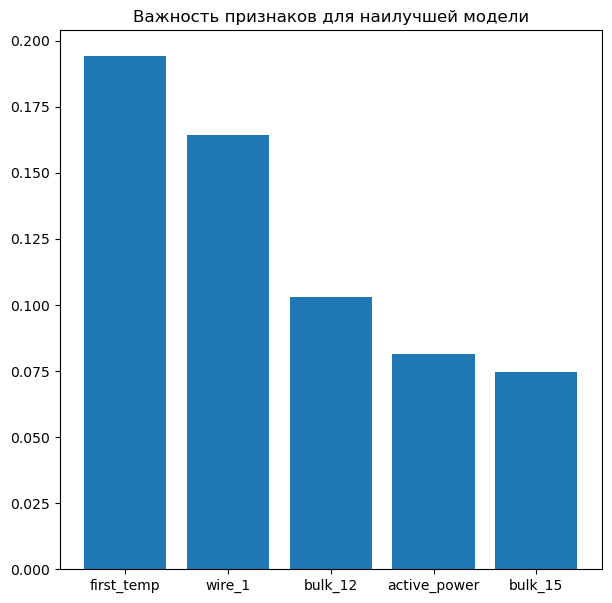

In [46]:
fig = plt.figure(figsize = (7, 7))
ax1 = fig.add_subplot(111)
ax2.set_title('Тип топлива')
ax1.bar(feature_importances_top_5.index, feature_importances_top_5)
ax1.set_title('Важность признаков для наилучшей модели')

### Итоговая модель

Наилучшая модель - RandomForestRegressor с гиперпараметрами:
- max_depth=10, 
- min_samples_split=30, 
- n_estimators=750,
- random_state=240423.

МАЕ на тестовой выборке наилучшей модели МАЕ = 6.403.